In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [128]:
import os
Root = "/content/drive/MyDrive/Colab_Notebook/Music_Genre_Classification"
os.chdir(Root)

[Dataset](https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification)

In [129]:
import pandas as pd
import numpy as np
import os
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

In [130]:
audio_dataset_path='/content/drive/MyDrive/Colab_Notebook/Music_Genre_Classification/Data/genres_original'
metadata=pd.read_csv('/content/drive/MyDrive/Colab_Notebook/Music_Genre_Classification/Data/features_30_sec.csv')
metadata.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,0.083045,0.000767,-4.529724e-05,0.008172,0.000008,0.005698,123.046875,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,0.056040,0.001448,1.395807e-04,0.005099,-0.000178,0.003063,67.999589,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,0.076291,0.001007,2.105576e-06,0.016342,-0.000019,0.007458,161.499023,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,0.033309,0.000423,4.583644e-07,0.019054,-0.000014,0.002712,63.024009,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,0.101461,0.001954,-1.756129e-05,0.004814,-0.000010,0.003094,135.999178,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


**Feature Extractor Function**

Mel Frequency Cepstral Coefficients:

These are state-of-the-art features used in automatic speech and speech recognition studies. There are a set of steps for generation of these features:

Since the audio signals are constantly changing, first we divide these signals into smaller frames. Each frame is around 20-40 ms long
Then we try to identify different frequencies present in each frame
Now, separate linguistic frequencies from the noise
To discard the noise, it then takes discrete cosine transform (DCT) of these frequencies. Using DCT we keep only a specific sequence of frequencies that have a high probability of information.

In [131]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [132]:
# metadata.drop(labels=552, axis=0, inplace=True)

In [133]:
from tqdm import tqdm
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients

extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    try:
        final_class_labels=row["label"]
        file_name = os.path.join(os.path.abspath(audio_dataset_path), final_class_labels+'/',str(row["filename"]))    
        data=features_extractor(file_name)
        extracted_features.append([data,final_class_labels])
    except Exception as e:
        print(f"Error: {e}")
        continue

553it [01:00,  8.28it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
555it [01:01,  3.54it/s]

Error: 


999it [01:50,  9.03it/s]


In [134]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-113.57065, 121.57179, -19.168142, 42.36642, ...",blues
1,"[-207.5017, 123.991264, 8.955127, 35.87765, 2....",blues
2,"[-90.722595, 140.4463, -29.09389, 31.684334, -...",blues
3,"[-199.5442, 150.09091, 5.6626782, 26.85908, 1....",blues
4,"[-160.3377, 126.219635, -35.58781, 22.148071, ...",blues


In [135]:
extracted_features_df['class'].value_counts()

metal        100
reggae       100
blues        100
pop          100
classical    100
country      100
hiphop       100
disco        100
rock         100
jazz          98
Name: class, dtype: int64

**Split the dataset into independent and dependent dataset**

In [136]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [137]:
X.shape

(998, 40)

In [138]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [139]:
y.shape

(998, 10)

**Train Test Split**

In [140]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [141]:
X_train

array([[-1.04675392e+02,  8.77509460e+01, -3.32513123e+01, ...,
        -2.38443661e+00, -1.36187017e+00, -7.19340086e-01],
       [-2.59876740e+02,  1.23187164e+02, -6.39084244e+00, ...,
        -6.73822832e+00, -3.91004443e+00,  3.17720938e+00],
       [-1.15707176e+02,  6.70756454e+01,  1.87352538e+00, ...,
        -3.44522524e+00, -1.73945498e+00, -4.34088111e-02],
       ...,
       [-1.24778605e+01,  9.13266830e+01, -2.30955830e+01, ...,
        -4.04354048e+00, -1.77468669e+00, -1.75448668e+00],
       [-2.37835236e+01,  8.29775314e+01,  2.33253670e+00, ...,
         1.41176534e+00,  4.12083626e-01, -4.17617001e-02],
       [-9.62648697e+01,  9.09442902e+01, -3.22151260e+01, ...,
        -2.40931821e+00, -1.65089101e-01, -1.84808576e+00]], dtype=float32)

In [142]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(798, 40)
(200, 40)
(798, 10)
(200, 10)


In [143]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [144]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [145]:
### No of classes
num_labels=y.shape[1]

In [172]:
y.shape[1]

10

In [157]:
model=Sequential()
model.add(Dense(1024,input_shape=(40,), activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.3))

###final layer
model.add(Dense(num_labels, activation="softmax"))

In [158]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 1024)              41984     
_________________________________________________________________
dropout_52 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_68 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_53 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_54 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 128)             

In [159]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [160]:
import time
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)

In [161]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath=f'saved_models/audio_classification_{current_time}.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
25/25 [==============================] - 1s 26ms/step - loss: 4.6124 - accuracy: 0.0977 - val_loss: 2.2928 - val_accuracy: 0.0750

Epoch 00001: val_loss improved from inf to 2.29281, saving model to saved_models/audio_classification_18:38:48.hdf5
Epoch 2/100
25/25 [==============================] - 0s 17ms/step - loss: 2.6447 - accuracy: 0.1115 - val_loss: 2.2903 - val_accuracy: 0.1550

Epoch 00002: val_loss improved from 2.29281 to 2.29027, saving model to saved_models/audio_classification_18:38:48.hdf5
Epoch 3/100
25/25 [==============================] - 0s 17ms/step - loss: 2.4142 - accuracy: 0.1216 - val_loss: 2.2707 - val_accuracy: 0.1100

Epoch 00003: val_loss improved from 2.29027 to 2.27070, saving model to saved_models/audio_classification_18:38:48.hdf5
Epoch 4/100
25/25 [==============================] - 0s 18ms/step - loss: 2.3372 - accuracy: 0.1253 - val_loss: 2.2740 - val_accuracy: 0.2000

Epoch 00004: val_loss did not improve from 2.27070
Epoch 5/100
25/25 [==

In [162]:
model.evaluate(X_test,y_test,verbose=0)

[1.8274377584457397, 0.5899999737739563]

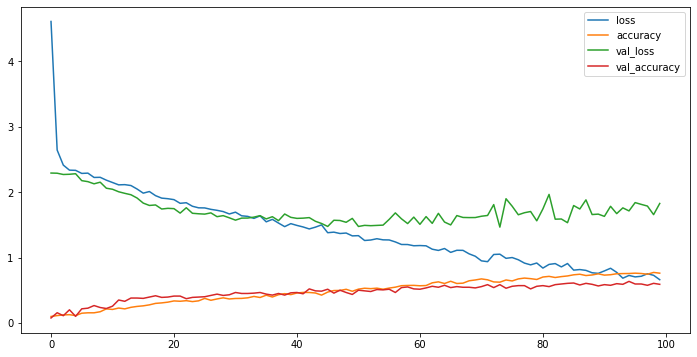

In [163]:
pd.DataFrame(history.history).plot(figsize=(12,6))
plt.show()

In [164]:
model.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 7, 0, 3, 6, 7, 5, 2, 8, 9, 6, 4, 1, 1, 5, 7, 6, 5, 9, 0, 4, 5,
       3, 0, 1, 7, 5, 5, 0, 6, 7, 4, 0, 4, 6, 6, 3, 5, 2, 7, 6, 9, 5, 3,
       0, 8, 8, 3, 5, 6, 5, 8, 6, 5, 2, 2, 9, 2, 3, 6, 9, 8, 9, 9, 4, 2,
       1, 4, 9, 1, 6, 3, 9, 9, 4, 9, 5, 4, 6, 9, 5, 6, 8, 3, 2, 5, 8, 5,
       4, 0, 3, 0, 9, 4, 6, 7, 7, 5, 0, 2, 5, 5, 4, 8, 1, 4, 7, 8, 1, 6,
       0, 4, 9, 3, 6, 2, 4, 6, 3, 5, 4, 8, 2, 9, 3, 7, 1, 2, 0, 7, 2, 0,
       5, 4, 1, 2, 8, 4, 9, 2, 9, 9, 0, 0, 3, 0, 4, 3, 4, 2, 6, 4, 3, 8,
       8, 6, 4, 3, 4, 8, 6, 5, 6, 4, 7, 1, 7, 2, 7, 5, 8, 6, 1, 7, 7, 1,
       4, 7, 8, 3, 8, 3, 9, 0, 8, 8, 0, 6, 4, 7, 6, 6, 1, 2, 8, 9, 6, 2,
       2, 1])

In [174]:
filename="/content/drive/MyDrive/Colab_Notebook/Music_Genre_Classification/audio/blues.00000.wav"
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predicted_label=model.predict_classes(mfccs_scaled_features)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class

[-1.1357065e+02  1.2157179e+02 -1.9168142e+01  4.2366421e+01
 -6.3646641e+00  1.8623499e+01 -1.3704891e+01  1.5343150e+01
 -1.2274110e+01  1.0976572e+01 -8.3265734e+00  8.8037930e+00
 -3.6723001e+00  5.7479949e+00 -5.1628819e+00  7.5273985e-01
 -1.6902149e+00 -4.0897894e-01 -2.3035226e+00  1.2212901e+00
 -3.5343504e+00 -1.1414334e+00 -4.2830324e+00 -4.2261953e+00
  9.1561663e-01  9.1268736e-01 -5.7613473e+00 -3.9327433e+00
  1.5108240e+00  2.6988823e+00  5.6574712e+00 -3.2662375e+00
 -2.0303418e-01 -3.0002940e+00  4.4772325e+00 -4.7590593e-01
  6.0092382e+00 -5.8892559e-02 -3.4585075e+00 -1.8423905e+00]
[[-1.1357065e+02  1.2157179e+02 -1.9168142e+01  4.2366421e+01
  -6.3646641e+00  1.8623499e+01 -1.3704891e+01  1.5343150e+01
  -1.2274110e+01  1.0976572e+01 -8.3265734e+00  8.8037930e+00
  -3.6723001e+00  5.7479949e+00 -5.1628819e+00  7.5273985e-01
  -1.6902149e+00 -4.0897894e-01 -2.3035226e+00  1.2212901e+00
  -3.5343504e+00 -1.1414334e+00 -4.2830324e+00 -4.2261953e+00
   9.1561663e-01 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array(['blues'], dtype='<U9')